In [1]:
import pandas as pd

fire_data = pd.read_csv(r'C:\Users\natal\Desktop\IRC\IRC-Group5\IRC-Group5\fire_data8423.csv')
fire_data = fire_data.dropna()
pivoted_weather= pd.read_csv(r'weather_pivoted.csv')
# Drop columns if they exist
columns_to_drop = ['CONT_DATE', '_id']
fire_data = fire_data.drop(columns=[col for col in columns_to_drop if col in fire_data.columns])
#try merging with unpivoted index weather data, tall and skinny data

print(pivoted_weather['date'].dtype)
print(fire_data['ALARM_DATE'].dtype)


object
object


In [2]:

# Convert 'date' column to datetime
pivoted_weather['date'] = pd.to_datetime(pivoted_weather['date'])
fire_data['ALARM_DATE'] = pd.to_datetime(fire_data['ALARM_DATE'])

#Filter rows between 1984-01-01 and 2023-12-31
pivoted_weather = pivoted_weather[(pivoted_weather['date'] >= '1984-01-01') & (pivoted_weather['date'] <= '2023-12-31')]
fire_data = fire_data[(fire_data['ALARM_DATE'] >= '19840101') & (fire_data['ALARM_DATE'] <= '20231231')]



In [3]:
# Rename columns to match index names before setting index
pivoted_weather.rename(columns={'id': 'weatherstn', 'date': 'ALARM_DATE'}, inplace=True)

# Set index before merging (Speeds up join operations)
pivoted_weather.set_index(['weatherstn', 'ALARM_DATE'], inplace=True)
fire_data.set_index(['weatherstn', 'ALARM_DATE'], inplace=True)

# Perform index-based merge
pivotedweather_fire_merge = pivoted_weather.merge(fire_data, left_index=True, right_index=True, how='left')

# Reset index if needed
pivotedweather_fire_merge.reset_index(inplace=True)

To get only days with fire

In [4]:
pivotedweather_fire_merge_reg= pivotedweather_fire_merge[pivotedweather_fire_merge['Shape__Area'].notna()]

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Generating the regression df by dropping rows with NaN in 'Shape__Area'
# pivot_regression_ver = pivotedweather_fire_merge_reg.fillna(0)

import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])
X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
print(np.round(imp.transform(X_test)))


[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
pivotedweather_fire_merge_reg= pd.read_csv(r'pivotedweather_fire_merge_reg.csv')
#check NaN in each column
column_notnull = pivotedweather_fire_merge_reg.notnull().sum()

column_todrop= column_notnull.index[column_notnull<50].to_list()

pivotedweather_fire_merge_drop = pivotedweather_fire_merge_reg.drop(columns=column_todrop)
#pivotedweather_fire_merge_drop is the one with most empty column dropped


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Load data
pivotedweather_fire_merge_drop = pd.read_csv(r'pivotedweather_fire_merge_drop.csv')

# Select only numerical columns for imputation
numerical_cols = pivotedweather_fire_merge_drop.loc[:, 'EVAP':'WDMV'].columns  # If continuous
# If non-continuous, use:
# numerical_cols = ['EVAP', 'TEMP', 'HUMID', 'WDMV']  # Add all numerical column names manually

numerical_data = pivotedweather_fire_merge_drop[numerical_cols]

# Initialize and apply IterativeImputer
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)
numerical_data_imputed = imputer.fit_transform(numerical_data)

# Convert back to DataFrame
pivotedweather_fire_merge_drop[numerical_cols] = numerical_data_imputed  # Only update imputed columns

# Check if missing values are handled
print(pivotedweather_fire_merge_drop.isnull().sum())




weatherstn           0
ALARM_DATE           0
EVAP                 0
MNPN                 0
MXPN                 0
PRCP                 0
SNOW                 0
SNWD                 0
TAVG                 0
TMAX                 0
TMIN                 0
TOBS                 0
WDMV                 0
Fire station name    0
UNIT_ID              0
GIS_ACRES            0
Shape__Area          0
Shape__Length        0
YEAR_                0
dtype: int64


c:\Users\natal\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [49]:
#rename the dataframe
pivoted_weather_ready = pd.read_csv(r'pivotedweather_fire_imputated.csv')
# Drop column: 'SNOW'
#pivoted_weather_ready = pivoted_weather_ready.drop(columns=['SNOW'])
# Define Features (X) and Target (y)

X = pivoted_weather_ready.loc[:, 'EVAP':'WDMV']  # Select numerical features
Y = pivoted_weather_ready[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]  # Target variables


#### 4 years training,2 years testing ML trial

In [61]:
##to do the 4 years train data, 2 years test data

# Define train/test date ranges
train_start = '2017-01-01'
train_end = '2020-12-31'  # 4 years for training
test_start = '2021-01-01'
test_end = '2022-12-31' # 2 years for testing

# Train-test split using date ranges
train_data = pivoted_weather_ready[
    (pivoted_weather_ready['ALARM_DATE'] >= train_start) & 
    (pivoted_weather_ready['ALARM_DATE'] <= train_end)
]

test_data = pivoted_weather_ready[
    (pivoted_weather_ready['ALARM_DATE'] >= test_start) & 
    (pivoted_weather_ready['ALARM_DATE'] <= test_end)
]

X_train42 = train_data.loc[:, 'EVAP':'WDMV']
Y_train42 = train_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]

X_test42 = test_data.loc[:, 'EVAP':'WDMV']
Y_test42 = test_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train Model
model42 = RandomForestRegressor(n_estimators=10, random_state=42)
model42.fit(X_train42, Y_train42)

# Predict
Y_pred42 = model42.predict(X_test42)

# Evaluate Performance
mse = mean_squared_error(Y_test42, Y_test42)
r2 = r2_score(Y_test42, Y_pred42)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')


Mean Squared Error: 0.0000
R² Score: -0.0625


Now the R2 score is -0.0549:
troubleshooting:
1. check if there is NaN in the columns
2. check feature correlation
3. plot a scatterplot between feature and fire parameters (area)

In [51]:
X_train42.isna().sum()
#none of the column has NAN
# Calculate the correlation matrix for the specified columns
correlation_matrix = pivoted_weather_ready.loc[:, 'EVAP':'WDMV'].join(pivoted_weather_ready.loc[:, 'GIS_ACRES':'Shape__Length']).corr()

# Print the correlation matrix
print(correlation_matrix)

                   EVAP      MNPN      MXPN      PRCP      SNWD      TAVG  \
EVAP           1.000000  0.738330  0.825430 -0.207756 -0.207782  0.828659   
MNPN           0.738330  1.000000  0.893118 -0.196266 -0.203241  0.910807   
MXPN           0.825430  0.893118  1.000000 -0.202742 -0.217721  0.958524   
PRCP          -0.207756 -0.196266 -0.202742  1.000000  0.224046 -0.240228   
SNWD          -0.207782 -0.203241 -0.217721  0.224046  1.000000 -0.312565   
TAVG           0.828659  0.910807  0.958524 -0.240228 -0.312565  1.000000   
TMAX           0.699048  0.847176  0.867228 -0.242713 -0.285901  0.915834   
TMIN           0.743617  0.807604  0.816376 -0.181434 -0.230275  0.844307   
TOBS           0.769961  0.783350  0.815955 -0.228342 -0.267662  0.816315   
WDMV          -0.300153 -0.591971 -0.647791  0.037200  0.071415 -0.637127   
GIS_ACRES      0.022042  0.023107  0.018943 -0.010354 -0.005949  0.019267   
Shape__Area    0.020787  0.021650  0.017761 -0.010146 -0.005856  0.017987   

### weather features against GIS_ACRES

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select features and target
features = ['EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDMV']  # Add other relevant features
target = 'GIS_ACRES'

# Scatterplots for each feature vs. fire size
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=pivoted_weather_ready[feature], y=pivoted_weather_ready[target])
    plt.xlim(pivoted_weather_ready[feature].min(), pivoted_weather_ready[feature].max())
    plt.ylim(pivoted_weather_ready[target].min(), pivoted_weather_ready[target].max())
    plt.xlabel(feature+"logscale")
    plt.ylabel(target)
    plt.title(f'{feature} vs {target}')
    plt.yscale('log') #log to see the data trend more clearly, normal scatter shows all datapoints stick to the bottom)
    plt.show()


#### Regression plot: show correlation, for loop

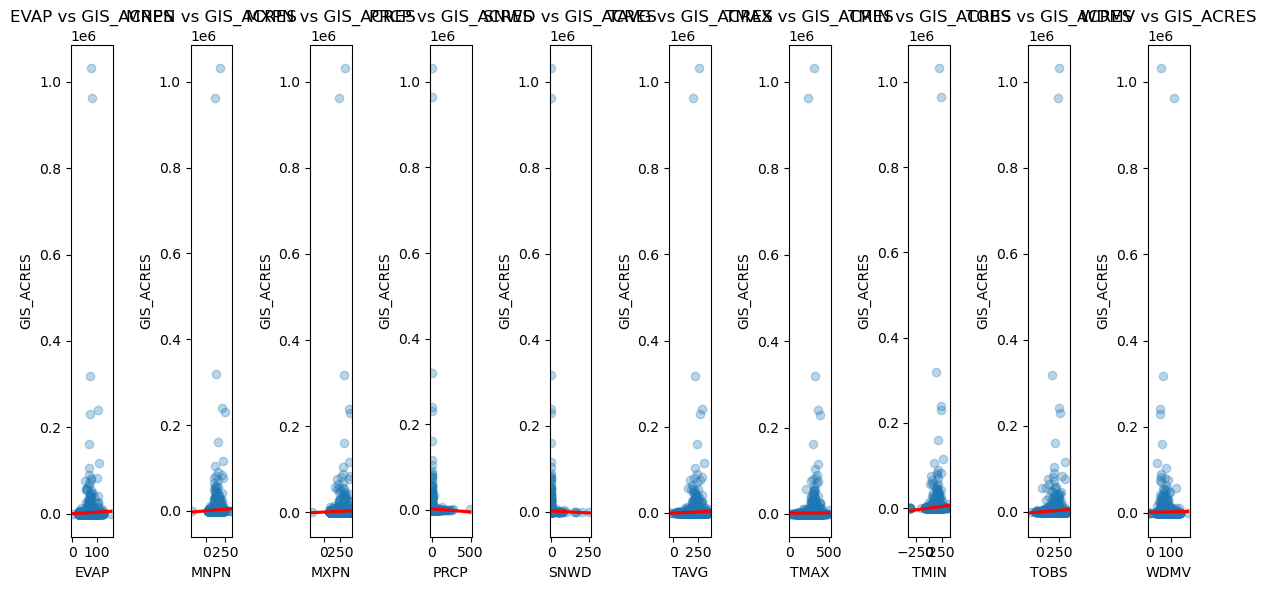

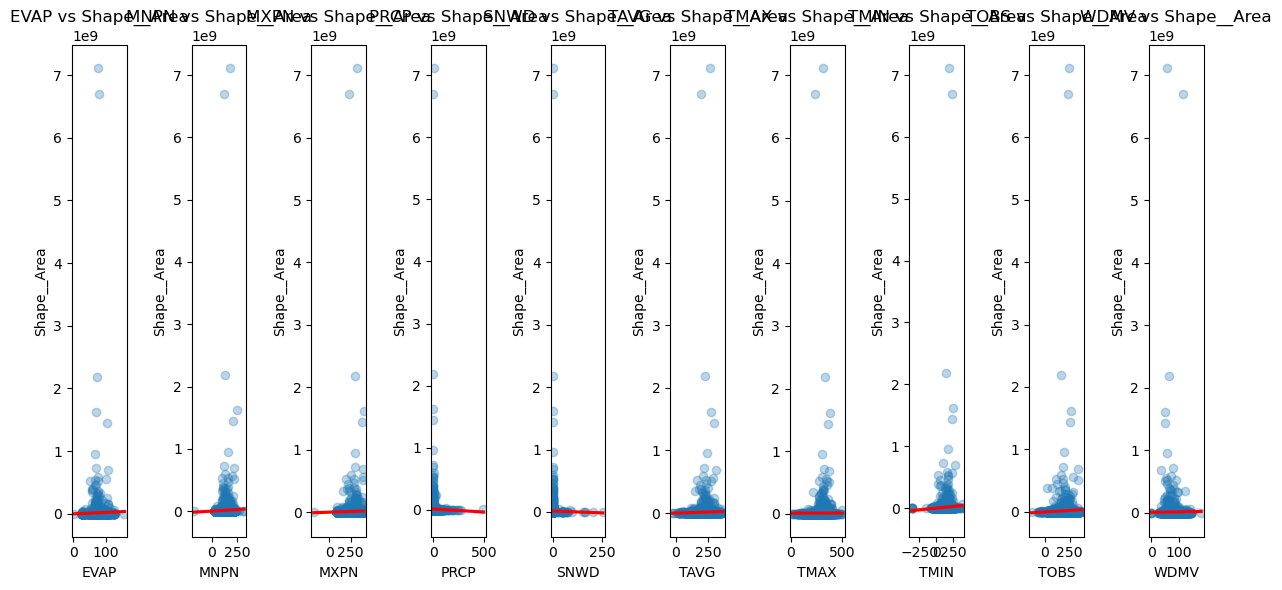

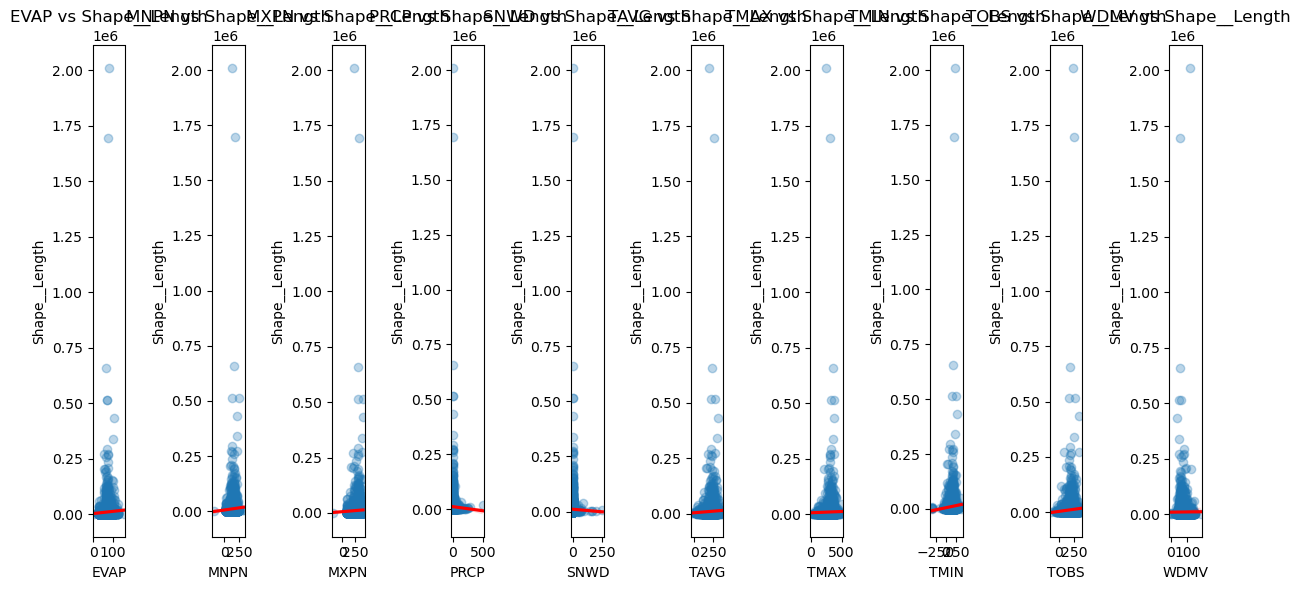

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define features and targets
features = ['EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDMV']  # Add other relevant features
targets = ['GIS_ACRES', 'Shape__Area', 'Shape__Length']

# Loop through each target variable
for target in targets:
    plt.figure(figsize=(12, 6))  # Adjust figure size
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i + 1)  # Arrange subplots in a row
        
        sns.regplot(x=pivoted_weather_ready[feature], 
                    y=pivoted_weather_ready[target], 
                    scatter_kws={'alpha': 0.3},  # Transparency for overlapping points
                    line_kws={'color': 'red'})  # Regression line in red
        
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.title(f"{feature} vs {target}")
    
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


#### Removed outlier to make graph look more focused on the most datapoints

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define features and targets
features = ['EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDMV']
targets = ['GIS_ACRES', 'Shape__Area', 'Shape__Length']

# Function to remove extreme outliers based on percentiles
def remove_outliers(df, feature, target, lower=1, upper=99):
    lower_bound_feature, upper_bound_feature = np.percentile(df[feature].dropna(), [lower, upper])
    lower_bound_target, upper_bound_target = np.percentile(df[target].dropna(), [lower, upper])
    
    return df[
        (df[feature] >= lower_bound_feature) & (df[feature] <= upper_bound_feature) &
        (df[target] >= lower_bound_target) & (df[target] <= upper_bound_target)
    ]

# Loop through each target variable
for target in targets:
    for feature in features:
        # Remove extreme outliers
        filtered_data = remove_outliers(pivoted_weather_ready, feature, target)
        
        # Create a separate figure for each feature-target pair
        plt.figure(figsize=(6, 4))  
        
        sns.regplot(x=filtered_data[feature], 
                    y=filtered_data[target], 
                    scatter_kws={'alpha': 0.3},  # Transparency for overlapping points
                    line_kws={'color': 'red'})  # Regression line in red
        
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.title(f"{feature} vs {target}")
        
        plt.show()


SyntaxError: incomplete input (666270264.py, line 32)

#### Shifting window for 4 years, 2 years train-test: for loop

In [ ]:
for start_year in range(2000, 2020, 2):  # Adjust range based on dataset
    train_years = list(range(start_year, start_year + 4))
    test_years = list(range(start_year + 4, start_year + 6))
    
    train_data = pivotedweather_fire_merge_drop[pivotedweather_fire_merge_drop['year'].isin(train_years)]
    test_data = pivotedweather_fire_merge_drop[pivotedweather_fire_merge_drop['year'].isin(test_years)]
    
    X_train, y_train = train_data.loc[:, 'EVAP':'WDMV'], train_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]
    X_test, y_test = test_data.loc[:, 'EVAP':'WDMV'], test_data[['GIS_ACRES', 'Shape__Area', 'Shape__Length']]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Train Years: {train_years} | Test Years: {test_years}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}, R²: {r2_score(y_test, y_pred):.4f}")
    print("-" * 50)


#### For the whole dataframe (classic 80/20 split)

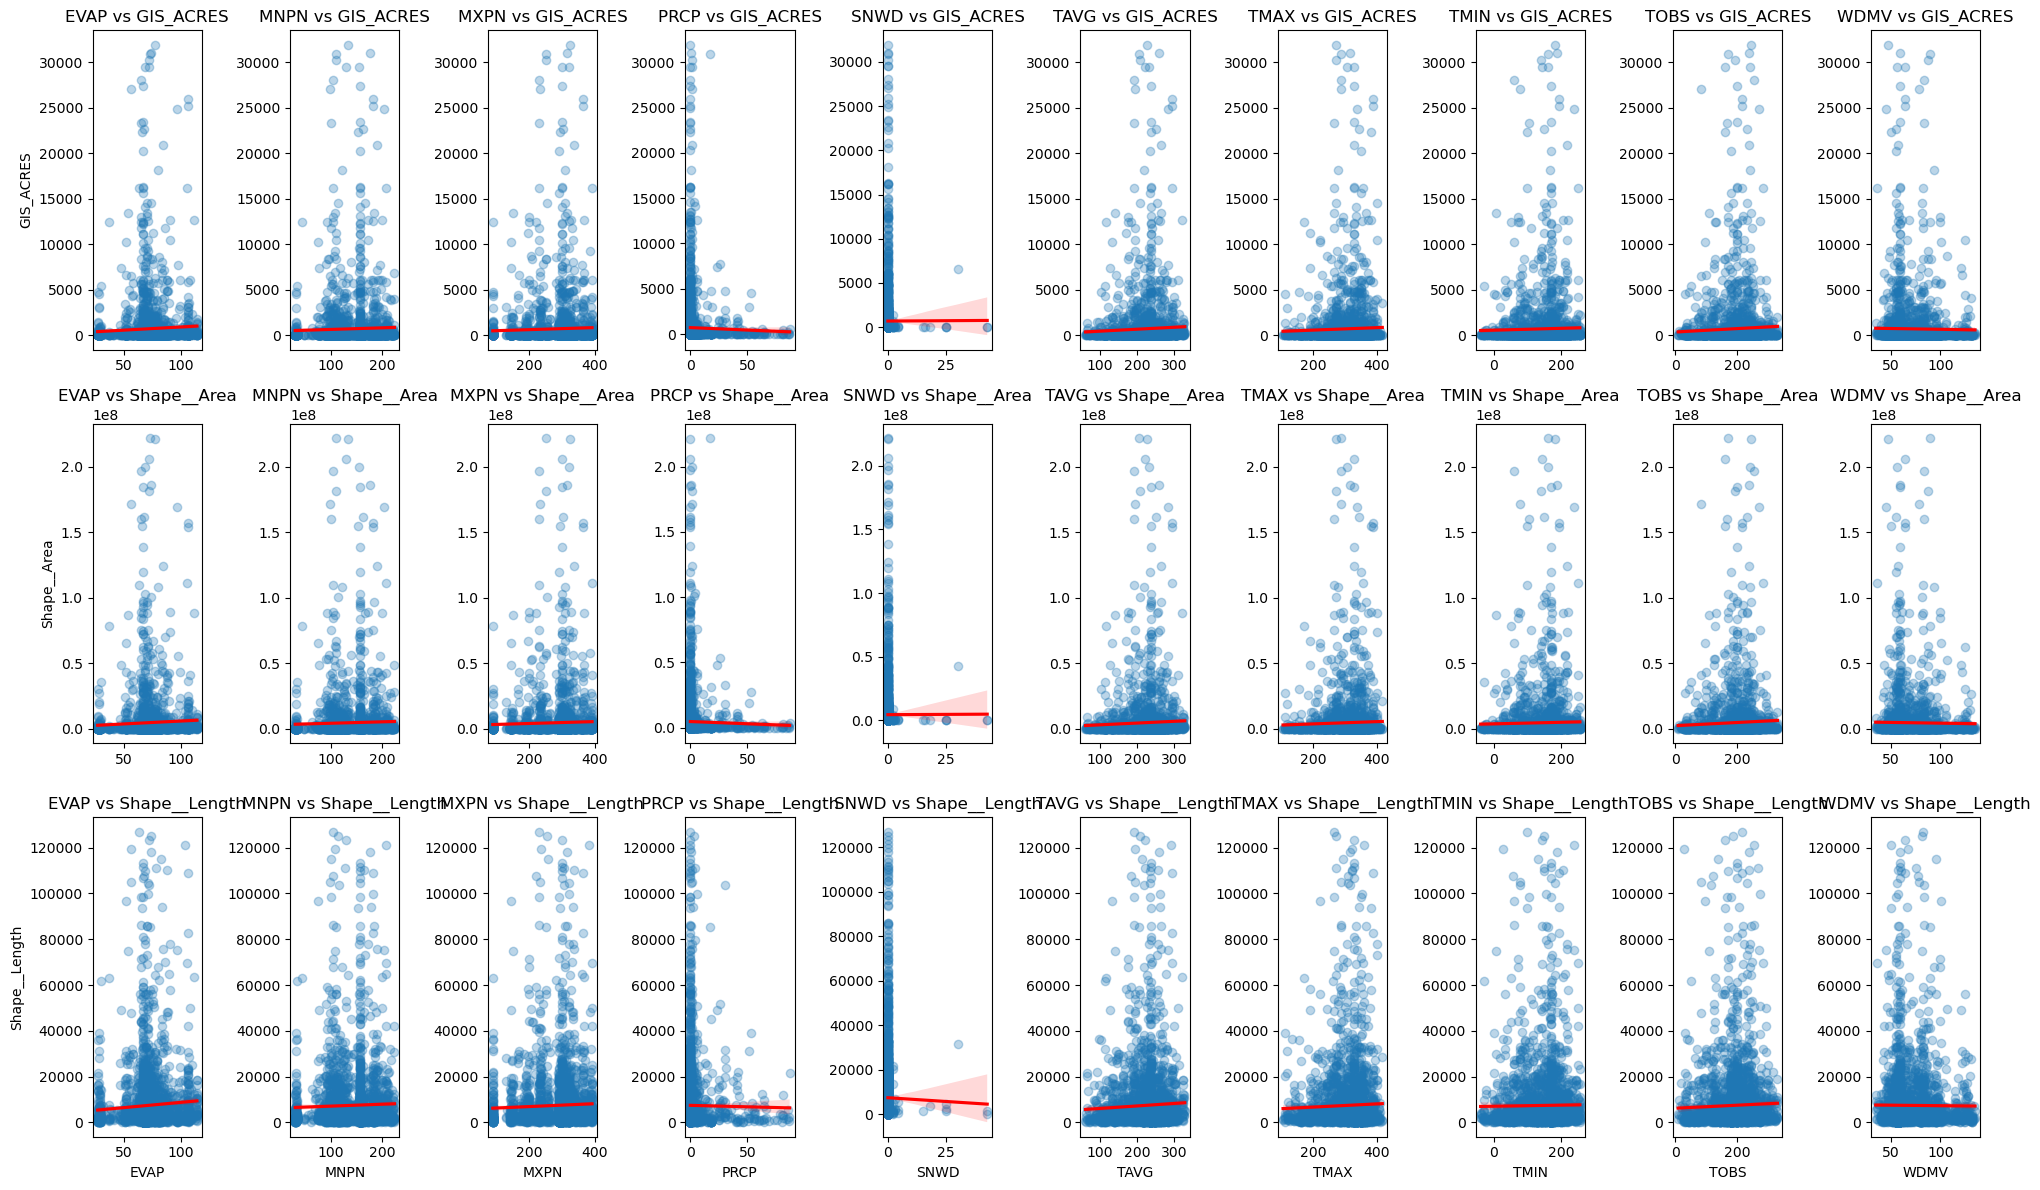

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define features and targets
features = ['EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDMV']
targets = ['GIS_ACRES', 'Shape__Area', 'Shape__Length']

# Function to remove extreme outliers based on percentiles
def remove_outliers(df, feature, target, lower=1, upper=99):
    lower_bound_feature, upper_bound_feature = np.percentile(df[feature].dropna(), [lower, upper])
    lower_bound_target, upper_bound_target = np.percentile(df[target].dropna(), [lower, upper])
    
    return df[
        (df[feature] >= lower_bound_feature) & (df[feature] <= upper_bound_feature) & 
        (df[target] >= lower_bound_target) & (df[target] <= upper_bound_target)
    ]

# Create a figure with subplots
fig, axes = plt.subplots(len(targets), len(features), figsize=(20, 12))

# Loop through each target and feature to create scatter plots
for i, target in enumerate(targets):
    for j, feature in enumerate(features):
        # Remove extreme outliers for this feature-target pair
        filtered_data = remove_outliers(pivoted_weather_ready, feature, target)
        
        # Create a scatter plot in the respective subplot
        ax = axes[i, j]
        
        sns.regplot(x=filtered_data[feature], 
                    y=filtered_data[target], 
                    scatter_kws={'alpha': 0.3},  # Transparency for overlapping points
                    line_kws={'color': 'red'},   # Regression line in red
                    ax=ax)
        
        # Set titles and labels
        if i == len(targets) - 1:  # Only label x-axis in the last row
            ax.set_xlabel(feature)
        else:
            ax.set_xlabel('')
        
        if j == 0:  # Only label y-axis in the first column
            ax.set_ylabel(target)
        else:
            ax.set_ylabel('')
        
        ax.set_title(f"{feature} vs {target}")

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:

from sklearn.model_selection import train_test_split

# Split Data (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(2979, 57)


c:\Users\natal\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


RandomForestRegressor(n_estimators=50, oob_score=True, random_state=42)

In [51]:
# Make predictions
Y_pred = model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"OOB Score: {model.oob_score_}")

Mean Squared Error: 1754470232327146.2
R-squared: -0.6942284880543953
OOB Score: -0.04685771879424094
